In [1]:
import pandas as pd
import seaborn as sns
import gradio as gr
import warnings
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
warnings.filterwarnings("ignore")

# Data Analysis

In [2]:
df = pd.read_csv("Heart Disease.csv")
dfgr = df.copy()
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3,30,No,Female,55-59,White,Yes,Yes,Very good,5,Yes,No,Yes
1,No,20.34,No,No,Yes,0,0,No,Female,80 or older,White,No,Yes,Very good,7,No,No,No
2,No,26.58,Yes,No,No,20,30,No,Male,65-69,White,Yes,Yes,Fair,8,Yes,No,No
3,No,24.21,No,No,No,0,0,No,Female,75-79,White,No,No,Good,6,No,No,Yes
4,No,23.71,No,No,No,28,0,Yes,Female,40-44,White,No,Yes,Very good,8,No,No,No


In [3]:
print(pd.concat([df.isnull().sum(), df.dtypes, df.nunique()],axis=1, keys=['Null values', 'Datatype', 'Unique values']))

                  Null values Datatype  Unique values
HeartDisease                0   object              2
BMI                         0  float64           3604
Smoking                     0   object              2
AlcoholDrinking             0   object              2
Stroke                      0   object              2
PhysicalHealth              0    int64             31
MentalHealth                0    int64             31
DiffWalking                 0   object              2
Sex                         0   object              2
AgeCategory                 0   object             13
Race                        0   object              6
Diabetic                    0   object              4
PhysicalActivity            0   object              2
GenHealth                   0   object              5
SleepTime                   0    int64             24
Asthma                      0   object              2
KidneyDisease               0   object              2
SkinCancer                  

In [4]:
categorical_cols = df.select_dtypes(include='object').columns
categorical_cols

Index(['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking',
       'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity',
       'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')

In [5]:
def printUnique(columns:list):
    for col in columns:
        print(f"{col}: {list(df[col].unique())}")

In [6]:
printUnique(categorical_cols)

HeartDisease: ['No', 'Yes']
Smoking: ['Yes', 'No']
AlcoholDrinking: ['No', 'Yes']
Stroke: ['No', 'Yes']
DiffWalking: ['No', 'Yes']
Sex: ['Female', 'Male']
AgeCategory: ['55-59', '80 or older', '65-69', '75-79', '40-44', '70-74', '60-64', '50-54', '45-49', '18-24', '35-39', '30-34', '25-29']
Race: ['White', 'Black', 'Asian', 'American Indian/Alaskan Native', 'Other', 'Hispanic']
Diabetic: ['Yes', 'No', 'No, borderline diabetes', 'Yes (during pregnancy)']
PhysicalActivity: ['Yes', 'No']
GenHealth: ['Very good', 'Fair', 'Good', 'Poor', 'Excellent']
Asthma: ['Yes', 'No']
KidneyDisease: ['No', 'Yes']
SkinCancer: ['Yes', 'No']


# Encoding

In [7]:
oenc = OrdinalEncoder(dtype=int)

#### Yes/NO columns

In [8]:
df['Diabetic'].replace({'No, borderline diabetes':'No', 'Yes (during pregnancy)':'Yes'}, inplace=True)
df['Diabetic'].unique()

array(['Yes', 'No'], dtype=object)

In [9]:
binary = [col for col in categorical_cols if df[col].nunique() is 2]
printUnique(binary)

HeartDisease: ['No', 'Yes']
Smoking: ['Yes', 'No']
AlcoholDrinking: ['No', 'Yes']
Stroke: ['No', 'Yes']
DiffWalking: ['No', 'Yes']
Sex: ['Female', 'Male']
Diabetic: ['Yes', 'No']
PhysicalActivity: ['Yes', 'No']
Asthma: ['Yes', 'No']
KidneyDisease: ['No', 'Yes']
SkinCancer: ['Yes', 'No']


In [10]:
df[binary] = oenc.fit_transform(df[binary])
df[binary].head()

,HeartDisease,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,Diabetic,PhysicalActivity,Asthma,KidneyDisease,SkinCancer
0,0,1,0,0,0,0,1,1,1,0,1
1,0,0,0,1,0,0,0,1,0,0,0
2,0,1,0,0,0,1,1,1,1,0,0
3,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,1,0,0,1,0,0,0


#### AgeCategory column

In [11]:
ages = df['AgeCategory'].unique()
ages

array(['55-59', '80 or older', '65-69', '75-79', '40-44', '70-74',
       '60-64', '50-54', '45-49', '18-24', '35-39', '30-34', '25-29'],
      dtype=object)

In [12]:
ages.sort()
pd.DataFrame({'RealValue': ages}).T

,0,1,2,3,4,5,6,7,8,9,10,11,12
RealValue,18-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80 or older


In [13]:
df[['AgeCategory']] = oenc.fit_transform(df[['AgeCategory']])
df['AgeCategory'].unique()

array([ 7, 12,  9, 11,  4, 10,  8,  6,  5,  0,  3,  2,  1])

#### GenHealth column

In [14]:
df['GenHealth'].unique()

array(['Very good', 'Fair', 'Good', 'Poor', 'Excellent'], dtype=object)

In [15]:
health_conditions = ['Poor', 'Fair', 'Good','Very good', 'Excellent']
oenc2 = OrdinalEncoder(categories=[health_conditions], dtype=int)
df[['GenHealth']] = oenc2.fit_transform(df[['GenHealth']])
df['GenHealth'].unique()

array([3, 1, 2, 0, 4])

#### Race column

In [16]:
print(list(df['Race'].unique()))

['White', 'Black', 'Asian', 'American Indian/Alaskan Native', 'Other', 'Hispanic']


In [17]:
df['Race'] = df['Race'].replace("American Indian/Alaskan Native", "American")
races = ['American', 'Asian', 'Black', 'Hispanic', 'White', 'Other']
print(races)

['American', 'Asian', 'Black', 'Hispanic', 'White', 'Other']


In [18]:
df = pd.concat([
    df.drop(columns=['Race'], axis=1),
    pd.get_dummies(df['Race'], prefix='race', dtype=int)],axis=1)

In [19]:
df.drop(columns=['race_Other'], axis=1, inplace=True)

# After Encoding

In [20]:
df.dtypes

HeartDisease          int64
BMI                 float64
Smoking               int64
AlcoholDrinking       int64
Stroke                int64
PhysicalHealth        int64
MentalHealth          int64
DiffWalking           int64
Sex                   int64
AgeCategory           int64
Diabetic              int64
PhysicalActivity      int64
GenHealth             int64
SleepTime             int64
Asthma                int64
KidneyDisease         int64
SkinCancer            int64
race_American         int64
race_Asian            int64
race_Black            int64
race_Hispanic         int64
race_White            int64
dtype: object

In [21]:
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,...,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,race_American,race_Asian,race_Black,race_Hispanic,race_White
0,0,16.60,1,0,0,3,30,0,0,7,...,3,5,1,0,1,0,0,0,0,1
1,0,20.34,0,0,1,0,0,0,0,12,...,3,7,0,0,0,0,0,0,0,1
2,0,26.58,1,0,0,20,30,0,1,9,...,1,8,1,0,0,0,0,0,0,1
3,0,24.21,0,0,0,0,0,0,0,11,...,2,6,0,0,1,0,0,0,0,1
4,0,23.71,0,0,0,28,0,1,0,4,...,3,8,0,0,0,0,0,0,0,1


# Visualization

In [22]:
def setGraphBG(title=False, xlabel=False, ylabel=False, xtick_angle=0, verbose=False):
   ax = plt.gca()
   ax.set_facecolor('#eff6ff')
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   ax.spines['left'].set_visible(False)
   ax.spines['bottom'].set_visible(False)

   if title: plt.title(title,fontsize=20)
   plt.xlabel(xlabel,fontsize=16) if xlabel else plt.xlabel('')
   plt.ylabel(ylabel,fontsize=16) if ylabel else plt.ylabel('')
   plt.xticks(rotation=xtick_angle, fontsize=13)

   if verbose:
      for p in ax.patches:
         ax.annotate(format(p.get_height(), '.4f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

## Correlation

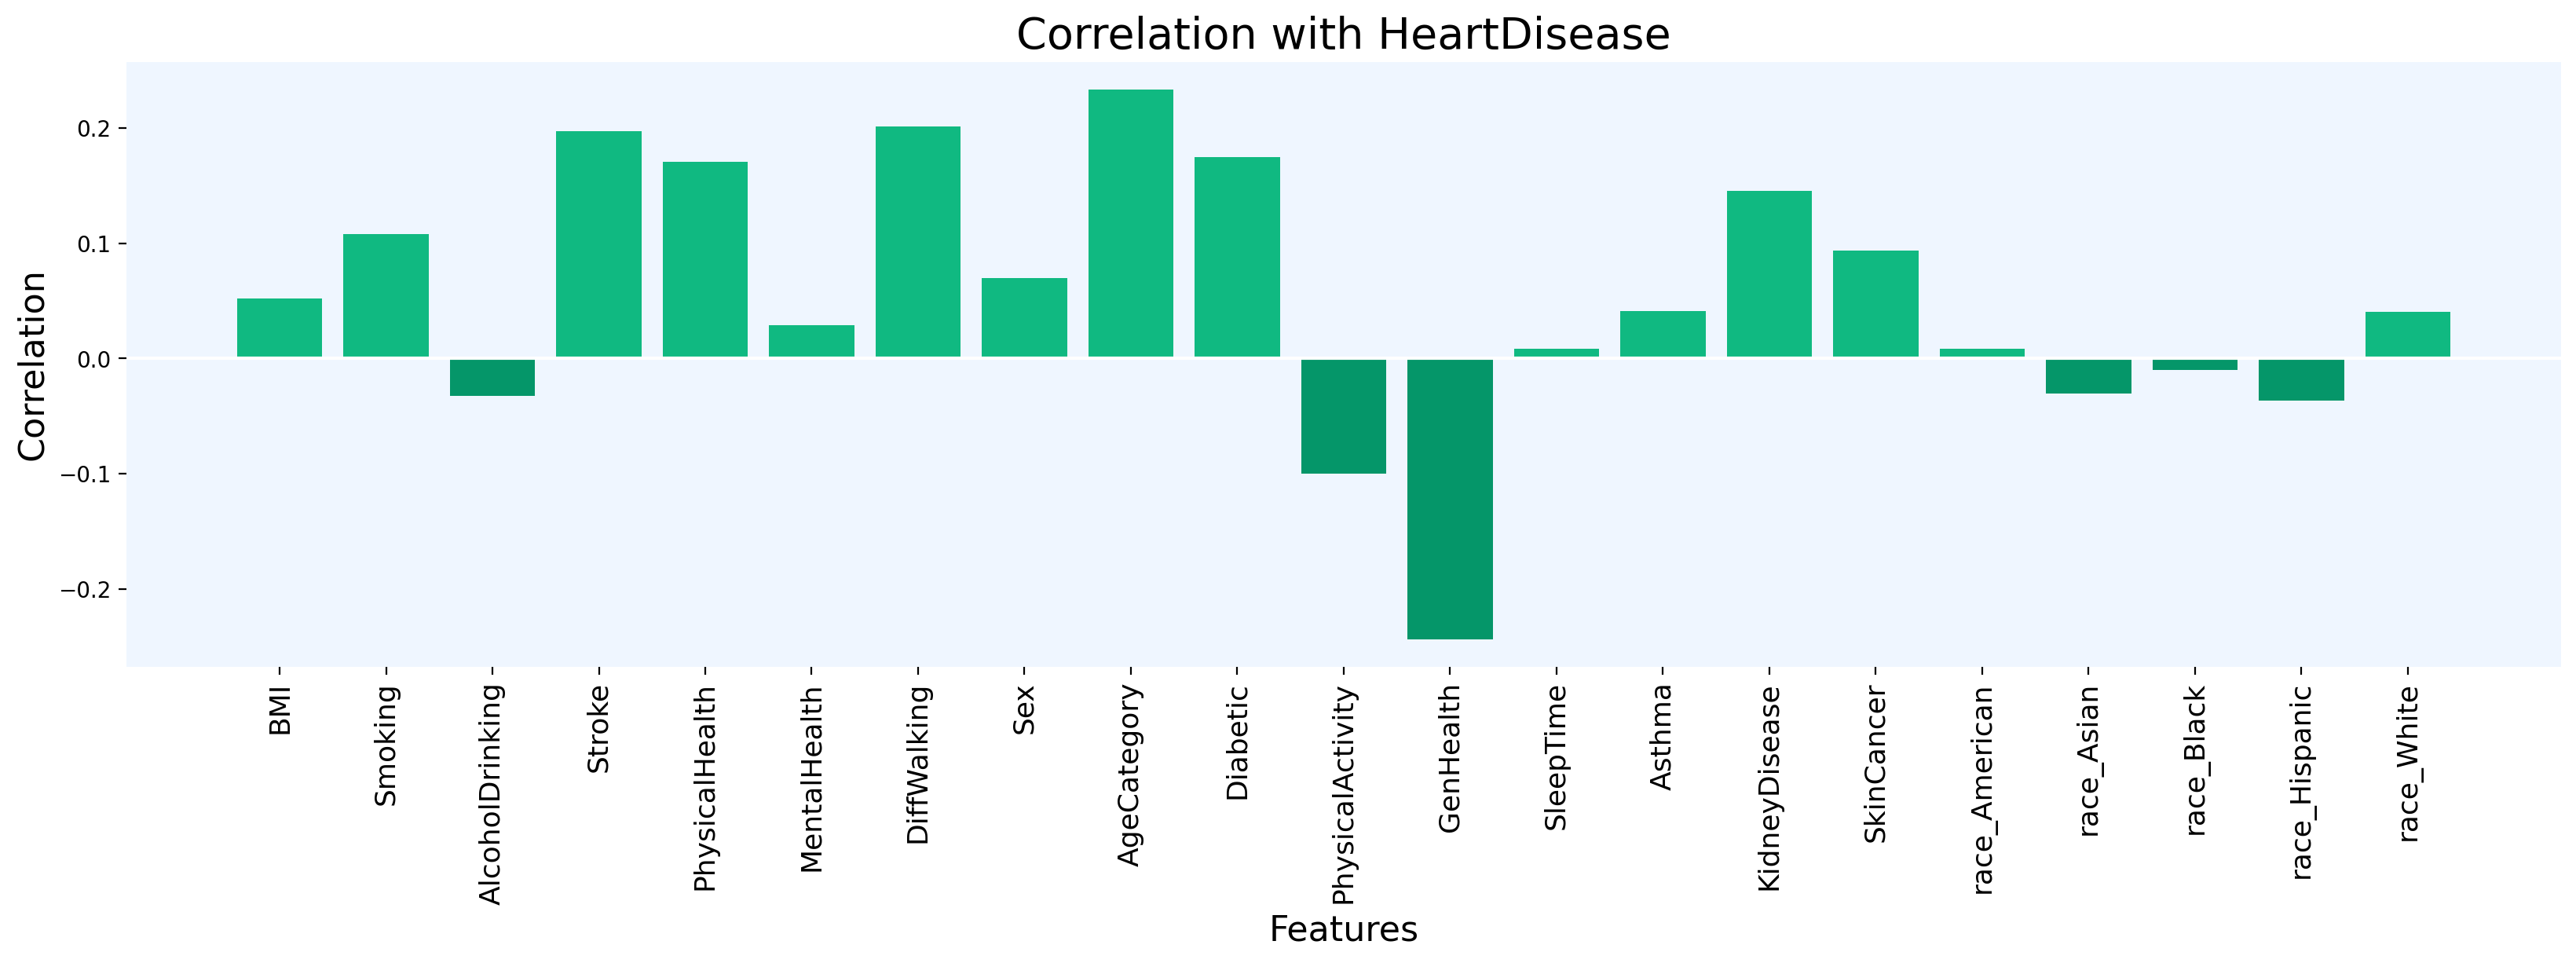

In [23]:
plt.figure(figsize=(20,5), dpi=200)
cor_df = df.corr()['HeartDisease']
cor_df.pop('HeartDisease')
colors = ['#10b981' if corr > 0 else '#059669' for corr in cor_df]
plt.bar(cor_df.index, cor_df, color=colors)
setGraphBG(title='Correlation with HeartDisease', xlabel='Features', ylabel='Correlation', xtick_angle=90)
plt.axhline(y=0, color='white')

### Remove unimportant columns and duplicates

In [24]:
print(f"Total records:\t{df.shape[0]}\nDuplicates:\t{df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
print(f"After cleaning:\t{df.shape[0]}")

Total records:	319795
Duplicates:	18491
After cleaning:	301304


### Feature and Target

In [25]:
x = df.drop(columns=['HeartDisease'], axis=1)
y = df['HeartDisease']

In [26]:
y.value_counts() # imbalance

HeartDisease
0    274047
1     27257
Name: count, dtype: int64

# Resampling

In [27]:
sampleinfo = [pd.Series(y.value_counts(), name='Before')]
over = RandomOverSampler(random_state=44)
x1,y1 = over.fit_resample(x,y)
sampleinfo.append(pd.Series(y1.value_counts(), name='After'))

In [28]:
df_sample = pd.concat(sampleinfo, axis=1).reset_index()
print(df_sample.drop(['HeartDisease'], axis=1))

   Before   After
0  274047  274047
1   27257  274047


# Training models

In [29]:
xtrain1, xtest1, ytrain1, ytest1 = tts(x1, y1, test_size=0.3, random_state=42)

In [30]:
model_names = ['Logistic Regression', 'Decision Tree', 'KNN', 'Random Forest']
traing_scores = []
testing_scores = []

# Logistic Regression

In [31]:
log = LogisticRegression()
log.fit(xtrain1, ytrain1)

LogisticRegression()

In [32]:
log_pred = log.predict(xtest1)
log_score = log.score(xtest1,ytest1)
log_score

0.7588259978470951

In [33]:
testing_scores.append(log_score)
traing_scores.append(log.score(xtrain1,ytrain1))
print(classification_report(ytest1, log_pred))

              precision    recall  f1-score   support

           0       0.77      0.74      0.75     82217
           1       0.75      0.78      0.76     82212

    accuracy                           0.76    164429
   macro avg       0.76      0.76      0.76    164429
weighted avg       0.76      0.76      0.76    164429



# Decision Tree

In [34]:
dt = DecisionTreeClassifier()
dt.fit(xtrain1, ytrain1)

DecisionTreeClassifier()

In [35]:
dt_pred = dt.predict(xtest1)
dt_score = dt.score(xtest1,ytest1)
dt_score

0.9471808500933534

In [36]:
testing_scores.append(dt_score)
traing_scores.append(dt.score(xtrain1,ytrain1))
print(classification_report(ytest1, dt_pred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.94     82217
           1       0.91      1.00      0.95     82212

    accuracy                           0.95    164429
   macro avg       0.95      0.95      0.95    164429
weighted avg       0.95      0.95      0.95    164429



# K-nearest neighbors (KNN)

In [37]:
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(xtrain1, ytrain1)

KNeighborsClassifier(n_jobs=-1)

In [38]:
knn_pred = knn.predict(xtest1)
knn_score = knn.score(xtest1,ytest1)
knn_score

0.8809394936416326

In [39]:
testing_scores.append(knn_score)
traing_scores.append(knn.score(xtrain1,ytrain1))
print(classification_report(ytest1, knn_pred))

              precision    recall  f1-score   support

           0       0.98      0.77      0.87     82217
           1       0.81      0.99      0.89     82212

    accuracy                           0.88    164429
   macro avg       0.90      0.88      0.88    164429
weighted avg       0.90      0.88      0.88    164429



# Random Forest

In [40]:
rf = RandomForestClassifier(n_jobs=-1, max_depth=40)
rf.fit(xtrain1,ytrain1)

RandomForestClassifier(max_depth=40, n_jobs=-1)

In [41]:
rf_pred = rf.predict(xtest1)
rf_score = rf.score(xtest1,ytest1)
rf_score

0.9617342439593989

In [42]:
testing_scores.append(rf_score)
traing_scores.append(rf.score(xtrain1,ytrain1))
print(classification_report(ytest1, rf_pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     82217
           1       0.93      1.00      0.96     82212

    accuracy                           0.96    164429
   macro avg       0.96      0.96      0.96    164429
weighted avg       0.96      0.96      0.96    164429



# Comparison

### Accuracy score

In [43]:
df_score = pd.DataFrame({'Model': model_names,'Training score':traing_scores,'Testing score':testing_scores})
df_score = pd.melt(df_score, id_vars=['Model'], var_name='Score Type', value_name='Accuracy')
df_score

,Model,Score Type,Accuracy
0,Logistic Regression,Training score,0.758988
1,Decision Tree,Training score,0.997831
2,KNN,Training score,0.915126
3,Random Forest,Training score,0.997701
4,Logistic Regression,Testing score,0.758826
5,Decision Tree,Testing score,0.947181
6,KNN,Testing score,0.880939
7,Random Forest,Testing score,0.961734


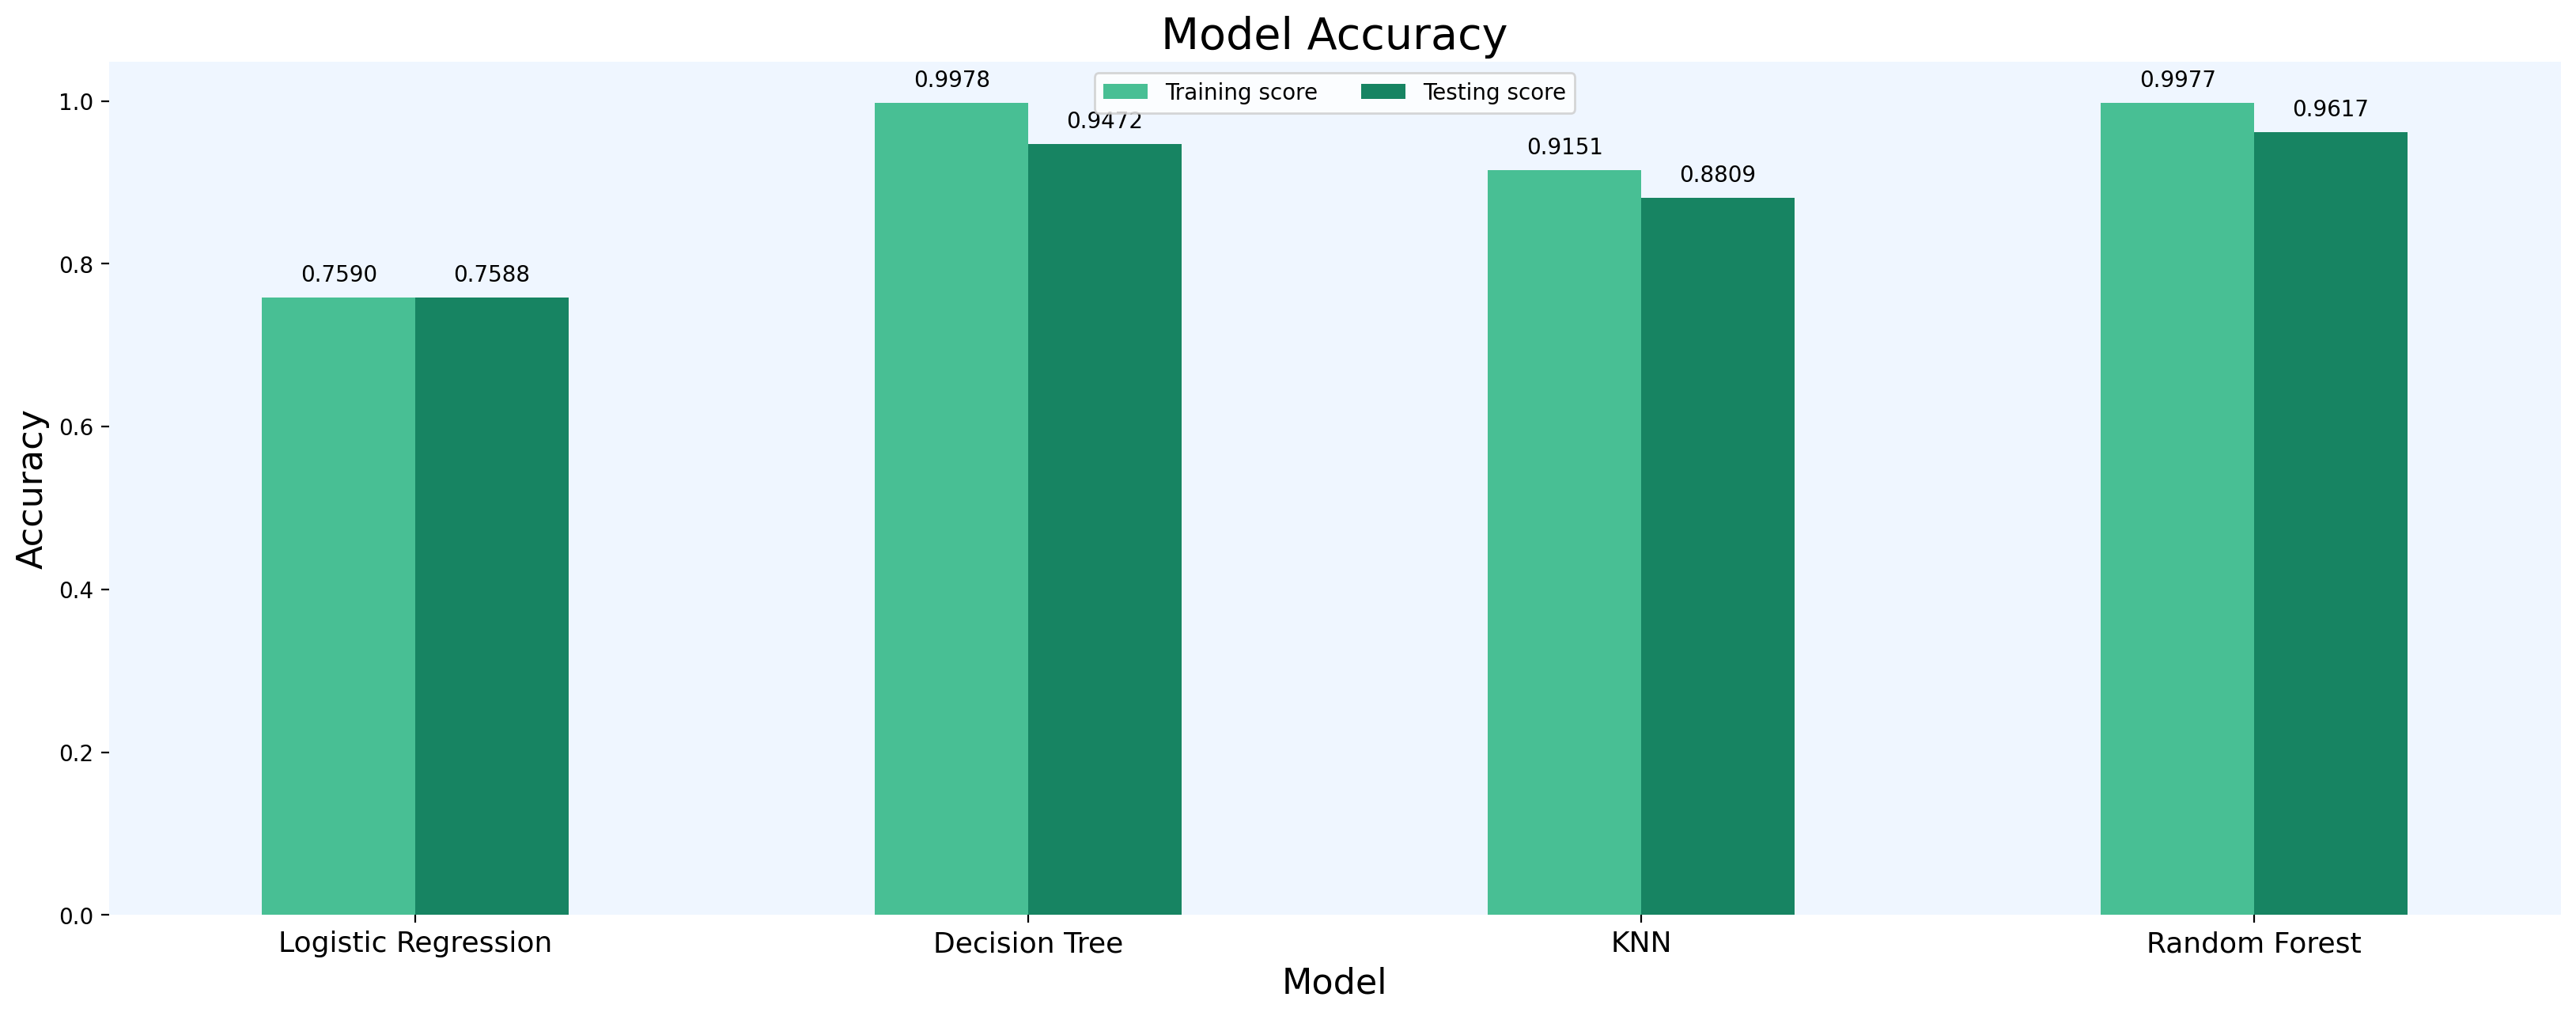

In [44]:
plt.figure(figsize=(20,7), dpi=200)
sns.barplot(data=df_score, x='Model', y='Accuracy', hue='Score Type', width=0.5, palette=['#34d399', '#059669'])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=2)
setGraphBG(title='Model Accuracy', xlabel='Model', ylabel='Accuracy', verbose=True)

### Confusion Matrix

Text(0.5, 29.444444444444432, 'Random Forest')

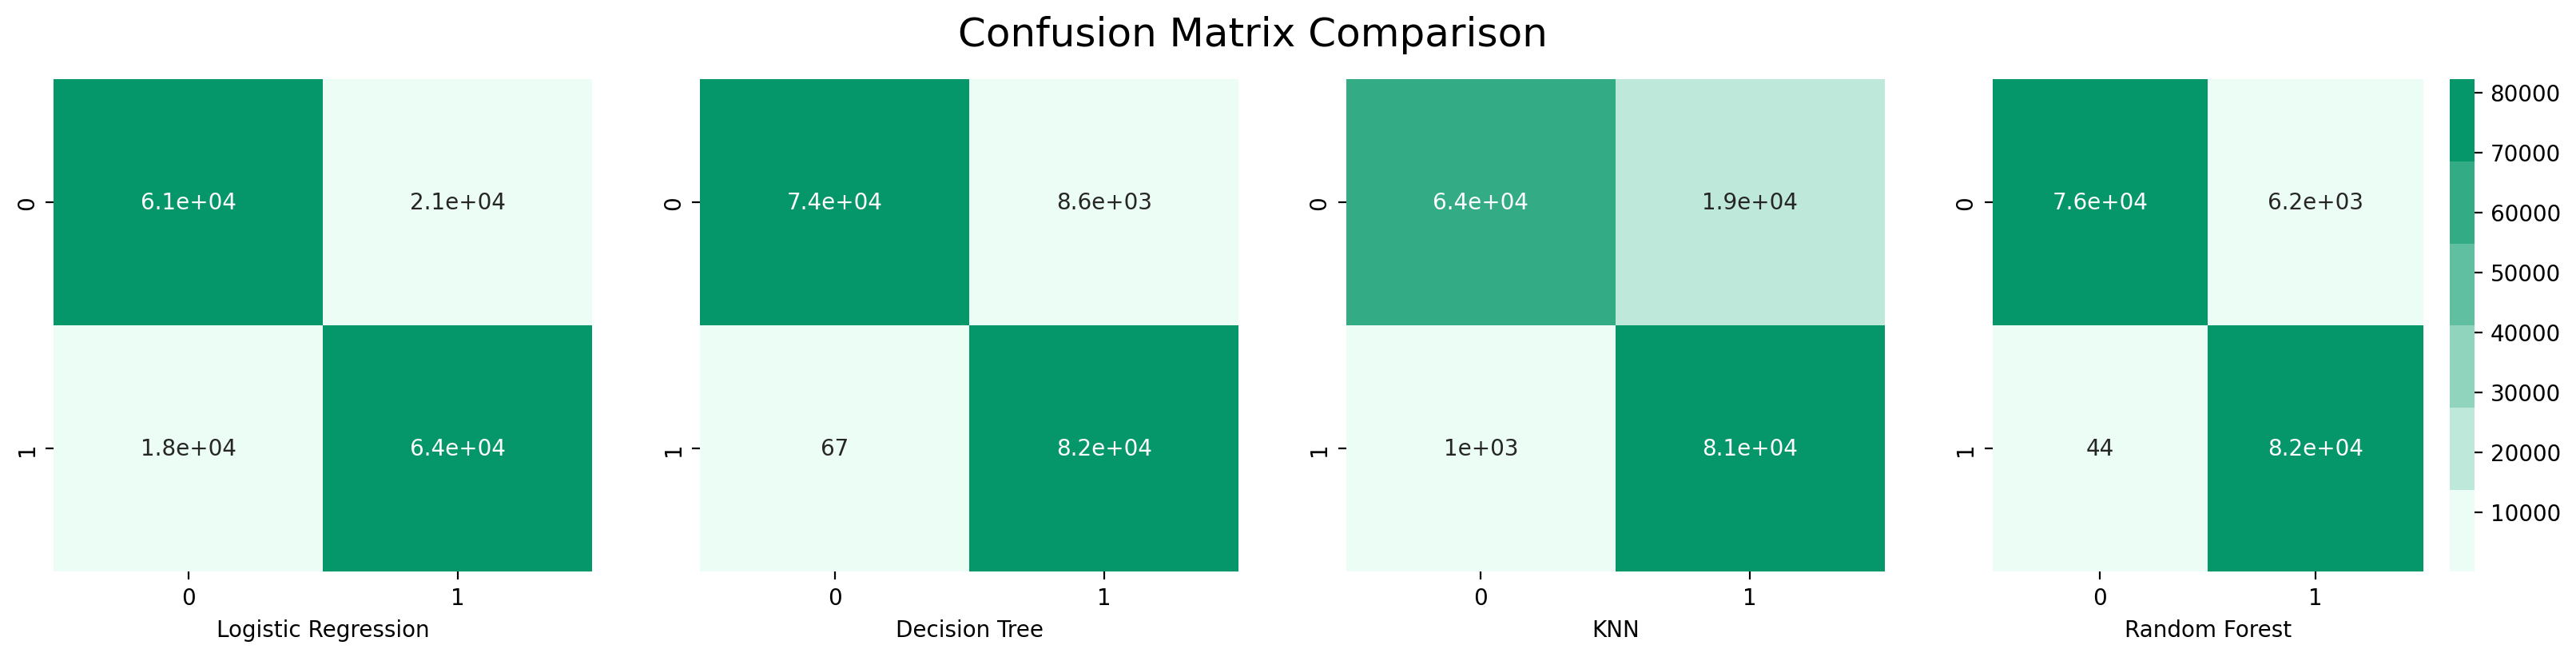

In [45]:
plt.figure(figsize=(20,4), dpi=200)
plt.suptitle("Confusion Matrix Comparison",fontsize=18)
colors = [(0,"#A7F3D0"),(0.2,"#6EE7B7"),(0.4,"#34D399"),(0.6,"#10B981"),(0.8,"#059669"),(1,"#047857")]
cmap = LinearSegmentedColormap.from_list('Custom', ['#ecfdf5','#059669'], len(colors))

plt.subplot(1,4,1)
sns.heatmap(confusion_matrix(ytest1, log_pred), annot=True, cmap=cmap, cbar=False)
plt.xlabel('Logistic Regression')

plt.subplot(1,4,2)
sns.heatmap(confusion_matrix(ytest1, dt_pred), annot=True, cmap=cmap, cbar=False)
plt.xlabel('Decision Tree')


plt.subplot(1,4,3)
sns.heatmap(confusion_matrix(ytest1, knn_pred), annot=True, cmap=cmap, cbar=False)
plt.xlabel('KNN')

plt.subplot(1,4,4)
sns.heatmap(confusion_matrix(ytest1, rf_pred), annot=True, cmap=cmap)
plt.xlabel('Random Forest')

# Cross validation (Random Forest)

In [46]:
def PrintScore(cv_scores):
   print(f"Min score: {cv_scores.min()}")
   print(f"Max score: {cv_scores.max()}")
   print(f"Mean score: {cv_scores.mean()}")

### K-Fold Cross Validation

In [47]:
kf_scores = cross_val_score(rf, x1, y1, cv=KFold())
PrintScore(kf_scores)

Min score: 0.9192293306817249
Max score: 0.9998722837490194
Mean score: 0.9590362982188922


### Stratified K Fold Cross Validation

In [48]:
skf_scores = cross_val_score(rf, x1, y1, cv=StratifiedKFold())
PrintScore(skf_scores)

Min score: 0.9650516789972541
Max score: 0.9688463573500703
Mean score: 0.9667812493205691


# Gradio Interface

In [49]:
columns = list(df.columns[1:])

def ProcessInput(bmi,smoking,alcohol,stroke,physical_health,mental_health,walking,sex,age,race,diabetic,activity,gen_health,sleep,asthma,kidney,skin):
   data = ([0] * len(columns))

   # direct value
   values = [bmi,smoking,alcohol,stroke,physical_health,mental_health,walking,diabetic,activity,sleep,asthma,kidney,skin]
   keys = ['BMI','Smoking','AlcoholDrinking','Stroke','PhysicalHealth','MentalHealth','DiffWalking','Diabetic','PhysicalActivity','SleepTime','Asthma','KidneyDisease','SkinCancer']

   for key, value in zip(keys, values):
      data[columns.index(key)] = value

   # Processed value
   data[columns.index('Sex')] = 1 if sex=='Male' else 0
   data[columns.index('AgeCategory')] = list(ages).index(age)
   data[columns.index('GenHealth')] = list(health_conditions).index(gen_health)
   data[columns.index('race_'+race)] = 1

   return data

css = """.positive { background-color: #fb7185 } .negative { background-color: #34d399 }"""

with gr.Blocks(css=css) as demo:
    # Input Form
   gr.HTML('</br><h1 align="center">Heart Disease Prediction</h1>')
   with gr.Group():
      with gr.Row():
         bmi = gr.Number(label='BMI', value=16.6)
         physical_health = gr.Number(label='Physical Health', value=3)
         mental_health = gr.Number(label='Mental Health', value=30)
   with gr.Row():
      sleep = gr.Slider(label='SleepTime', minimum=0, maximum=24, step=1, value=5)
   with gr.Group():
      race = gr.Radio(label='Race', choices=races, value='White')
      sex = gr.Radio(label='Sex', choices=['Male', 'Female'], value='Female')
      age = gr.Radio(label='Age Category', choices=list(ages), value='55-59')
      gen_health = gr.Radio(label='General Health Condition', choices=health_conditions, value='Very good')
   with gr.Group():
      with gr.Row():
         smoking = gr.Checkbox(label='Smoking', value=True)
         alcohol = gr.Checkbox(label='AlcoholDrinking', value=False)
         walking = gr.Checkbox(label='Diff Walking', value=False)
         activity = gr.Checkbox(label='Physical Activity', value=True)
      with gr.Row():
         stroke = gr.Checkbox(label='Stroke', value=False)
         diabetic = gr.Checkbox(label='Diabetic', value=True)
         asthma = gr.Checkbox(label='Asthma', value=True)
         kidney = gr.Checkbox(label='Kidney Disease', value=False)
         skin = gr.Checkbox(label='Skin Cancer', value=True)
   with gr.Row():
      submit_btn = gr.Button("Submit")

   with gr.Column(visible=False) as output:
      Heart_Disease = gr.HTML()
      dataframe = gr.Dataframe()

   # Components
   input_components = [bmi,smoking,alcohol,stroke,physical_health,mental_health,walking,sex,age,race,diabetic,activity,gen_health,sleep,asthma,kidney,skin]
   output_components = [dataframe, output, Heart_Disease]

   def Submit(*values):
      input = ProcessInput(*values)
      df_input = pd.DataFrame([input], columns=columns)

      result = rf.predict([input])
      message = 'Congratulations! No Heart Disease' if result==0 else 'Unfortunately, the signs indicate Heart Disease'
      flag = 'negative' if result==0 else 'positive'
      html = f"<h2 align='center' class='{flag}'>{message}</h2>"

      return {output: gr.update(visible=True), dataframe:df_input, Heart_Disease:html}


   submit_btn.click(Submit, inputs=input_components, outputs=output_components)

    
demo.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
